In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
tf.keras.utils.set_random_seed(3)
from tqdm import tqdm
from tensorflow.keras.utils import plot_model
import time

# Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_path = "/content/drive/MyDrive/Cursos/TFM_AI/TFM/aplicacion/data/train.npz"
test_path = "/content/drive/MyDrive/Cursos/TFM_AI/TFM/aplicacion/data/test.npz"
model_path = "/content/drive/MyDrive/Cursos/TFM_AI/TFM/aplicacion/models/cvae-cgan.h5"

"""
train_path = "data/train.npz"
test_path = "data/test.npz"
model_path = "models/cvae-cgan.h5"
"""

'\ntrain_path = "data/train.npz"\ntest_path = "data/test.npz"\nmodel_path = "models/cvae-cgan.h5"\n'

In [4]:
train_data = np.load(train_path)
X_train = train_data["arr_0"]
y_train = train_data["arr_1"]
X_train.shape, y_train.shape

((10000, 128, 128, 1), (10000,))

In [5]:
test_data = np.load(test_path)
X_test = test_data["arr_0"]
y_test = test_data["arr_1"]
X_test.shape, y_test.shape

((400, 128, 128, 1), (400,))

In [6]:
X_train = X_train / 255.
X_test = X_test / 255.

# Model

In [7]:
latent_dim = 32
n_classes = 2
images_shape = X_train[0].shape # (128, 128, 1)

In [8]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
# Encoder
encoder_input = keras.Input(shape=images_shape)
label_input = keras.Input(shape=())
label = layers.Embedding(n_classes, np.prod(images_shape), input_length=1)(label_input)
label = layers.Reshape(images_shape)(label)

x = keras.layers.Concatenate()([encoder_input, label])

x1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x1)
x = tf.add(x, x1)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

x1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x1)
x = tf.add(x, x1)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

x1 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
x = tf.add(x, x1)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

x1 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x1)
x = tf.add(x, x1)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

shape_before_flattening = x.shape[1:]
print(shape_before_flattening)
x = layers.Flatten()(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x) 
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model([encoder_input, label_input], [z_mean, z_log_var, z], name="encoder") 
#we need to output also z_mean and z_log_var to calculate the kl loss
encoder.summary()

(8, 8, 256)
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 embedding (Embedding)          (None, 16384)        32768       ['input_2[0][0]']                
                                                                                                  
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 reshape (Reshape)              (None, 128, 128, 1)  0           ['embedding[0][

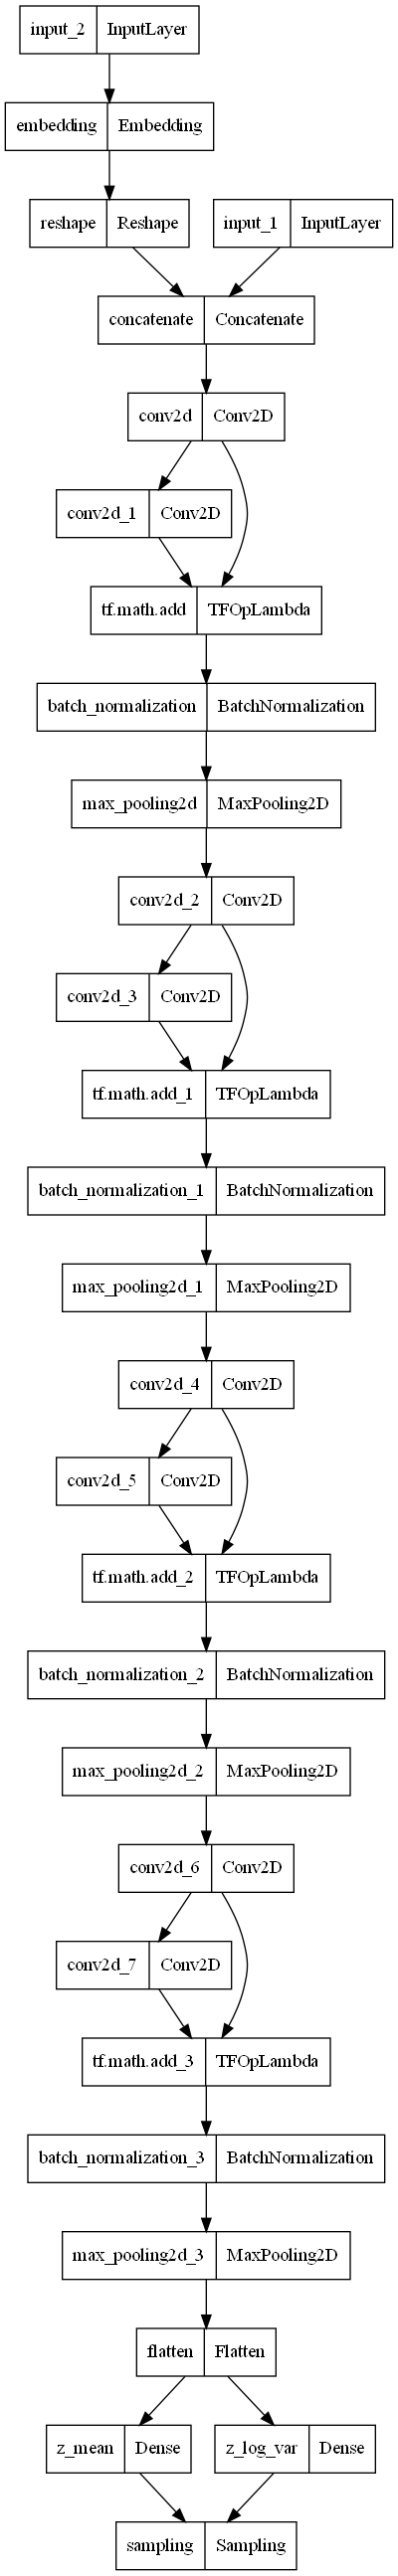

In [ ]:
plot_model(encoder)

In [ ]:
# Decoder
latent_input = keras.Input(shape=(latent_dim,), name='decoder_input')
label = layers.Embedding(n_classes, latent_dim, input_length=1)(label_input)
x = layers.Concatenate()([latent_input, label])
x = layers.Dense(np.prod(shape_before_flattening))(x)
x = layers.Reshape(shape_before_flattening)(x)

x1 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x1)
x = tf.add(x, x1)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)

x1 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
x = tf.add(x, x1)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)

x1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x1)
x = tf.add(x, x1)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)

x1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x1)
x = tf.add(x, x1)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)

decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

decoder = keras.Model([latent_input, label_input], decoded, name="decoder")
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 decoder_input (InputLayer)     [(None, 32)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 32)           64          ['input_2[0][0]']                
                                                                                                  
 concatenate_1 (Concatenate)    (None, 64)           0           ['decoder_input[0][0]',          
                                                                  'embedding_1[0][0]']      

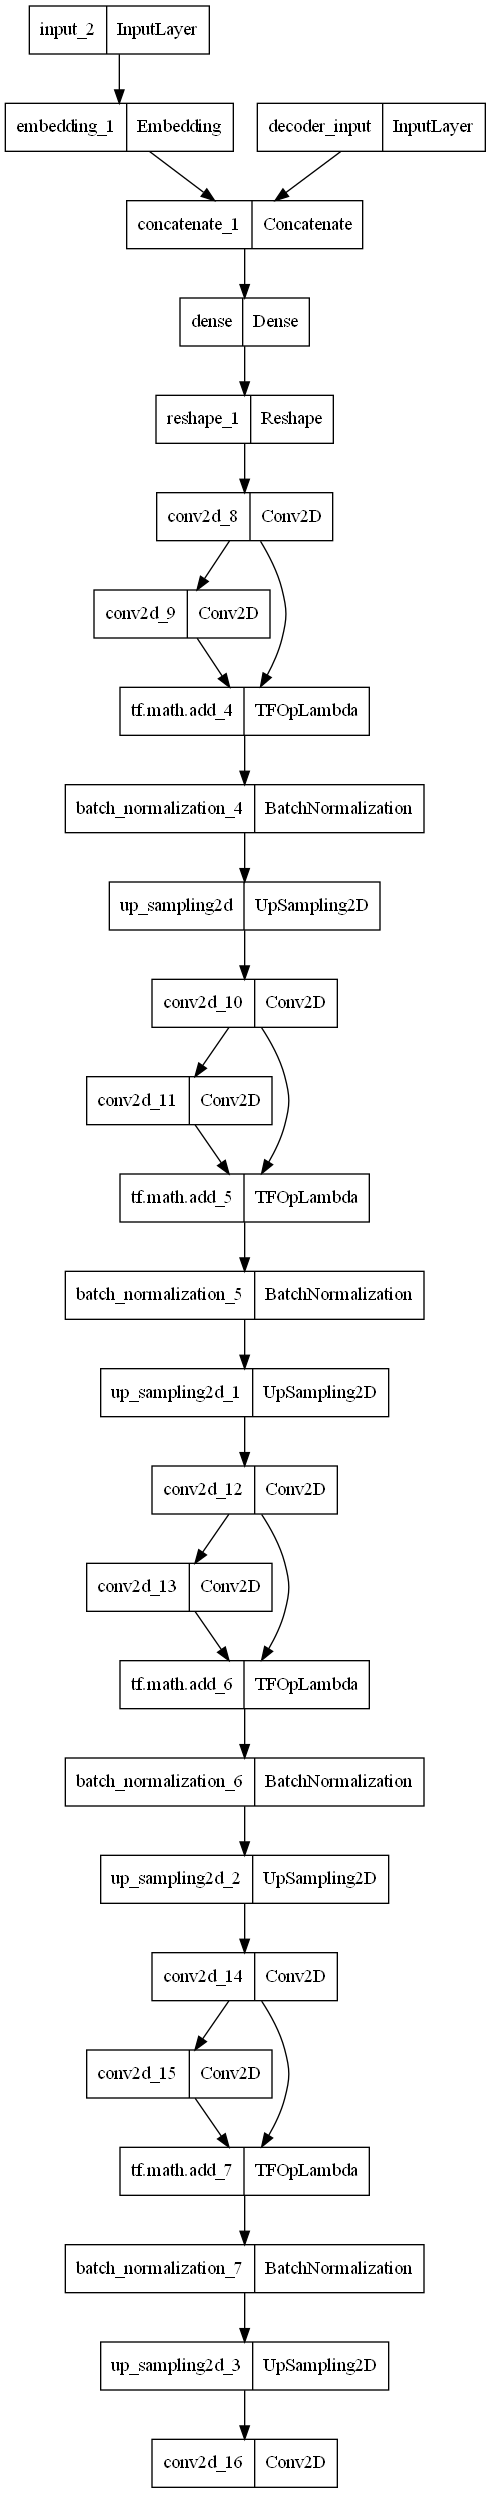

In [ ]:
plot_model(decoder)

In [ ]:
# VAE
encoder_input = keras.Input(shape=images_shape)
label_input = keras.Input(shape=())
z_mean, z_log_var, z = encoder([encoder_input, label_input])
decoded = decoder([z, label_input])
vae = keras.Model([encoder_input, label_input], decoded, name="vae")
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 encoder (Functional)           [(None, 32),         2255296     ['input_3[0][0]',                
                                 (None, 32),                      'input_4[0][0]']                
                                 (None, 32)]                                                    

In [ ]:
# Discriminador
discriminator_inputs = keras.Input(shape=images_shape)
label_input = keras.Input(shape=())
cond = layers.Embedding(n_classes, np.prod(images_shape), input_length=1)(label_input) #10 clases 
cond = layers.Reshape(images_shape)(cond)
x = keras.layers.Concatenate()([discriminator_inputs, cond])


x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.GlobalMaxPool2D()(x)

x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation="relu")(x)

discriminator_output = layers.Dense(1, activation="sigmoid")(x)

discriminator = keras.Model([discriminator_inputs, label_input], discriminator_output)
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 16384)        32768       ['input_6[0][0]']                
                                                                                                  
 input_5 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 reshape_2 (Reshape)            (None, 128, 128, 1)  0           ['embedding_2[0][0]']        

In [ ]:
from keras import backend as K
class VAE_GAN(keras.Model):    

    def __init__(self, vae, discriminator, **kwargs): #opti1=keras.optimizers.Adam(), opti2=keras.optimizers.Adam(), opti3=keras.optimizers.Adam(),
        super().__init__(**kwargs)
        
        self.encoder = vae.get_layer("encoder")#vae.encoder
        self.decoder = vae.get_layer("decoder")#vae.decoder
        self.discriminator = discriminator
        self.vae = vae
        
        self.vae_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        #self.correlation_loss_tracker = keras.metrics.Mean(name="cr_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="disc_loss")
        self.gen_loss_tracker = keras.metrics.Mean(name="gen_loss")
        self.disc_loss = keras.losses.BinaryCrossentropy()
        self.disc_accuracy = keras.metrics.BinaryAccuracy()
        
        
    def call(self,inputs):
        x, y = inputs
        z_mean, z_log_var, z = self.encoder([x, y])
        reconstruction = self.decoder([z, y])
        return reconstruction, z

    @property
    def metrics(self):
        return [
            self.vae_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            #self.correlation_loss_tracker,
            self.disc_loss_tracker,
            self.gen_loss_tracker
        ]
    
    def compile(self, **kwargs): #gen_optimizer=keras.optimizers.Adam(), 
        super().compile(**kwargs)
        lr = self.optimizer.lr
        self.vae_optimizer = keras.optimizers.Adam(lr) #this is a trick to get the lr of the default optimizer
        #as it is passing the reference the lr of our optimizers will also update with ReduceLROnPlateau
        self.disc_optimizer = keras.optimizers.Adam(lr)
        #self.gen_optimizer=keras.optimizers.Adam(lr) 

    def train_step(self, inputs): 
        data, label = inputs
        batch_size = K.shape(data)[0]    
        
        with tf.GradientTape() as enc_tape, tf.GradientTape() as disc_tape: # tf.GradientTape() as dec_tape
            z_mean, z_log_var, z = self.encoder([data, label])
            reconstruction = self.decoder([z, label])
            reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(keras.losses.mse(data, reconstruction), axis=(1, 2)))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            #coorelation_loss = corr_loss(z)
            
            
            # GAN
            recon_vect = z
            recon_vect2 = tf.random.normal((batch_size, latent_dim))

            contruction = self.decoder([recon_vect, label])
            contruction2 =  self.decoder([recon_vect2, label])

            combined_images = tf.concat([data, contruction], axis=0) #256
            data_l,recon_l = tf.zeros((batch_size, 1)),tf.ones((batch_size, 1))
            
            combined_l = tf.concat([data_l, recon_l], axis=0) #256
            double_label = tf.repeat(label, 2, axis=0)
            tot_predictions = self.discriminator([combined_images, double_label])
            
            contruction_total = tf.concat([contruction, contruction2], axis=0)
            r_prediction_total = self.discriminator([contruction_total, double_label])

            discr_loss = self.disc_loss(combined_l, tot_predictions)
            
            recon_l_tot = tf.ones((batch_size*2, 1))
            data_l_tot = tf.zeros((batch_size*2, 1))

            #fake labels : 
            #gen_loss =  self.disc_loss(data_l,r_prediction)
            #gen_loss =  tf.math.maximum(self.disc_loss(data_l,r_prediction), 0.0001)
            #gen_loss = tf.math.maximum(self.disc_loss(data_l,r_prediction) - discr_loss,.0001)
    
            #gen_loss =  tf.math.maximum(self.disc_loss(data_l_tot, r_prediction_total), 0.0001)
            gen_loss = tf.math.maximum(self.disc_loss(data_l_tot,r_prediction_total) - discr_loss,.0001) #this works better
        
            #=========
            vae_loss = reconstruction_loss + kl_loss + gen_loss #+.1*coorelation_loss 

               
        grad_discr = disc_tape.gradient(discr_loss, self.discriminator.trainable_weights)
        grad_vae = enc_tape.gradient(vae_loss, self.vae.trainable_weights)
        #grad_gen = dec_tape.gradient(gen_loss, self.decoder.trainable_weights)
        
        
        #self.gen_optimizer.apply_gradients(zip(grad_gen, self.decoder.trainable_weights))
        self.disc_optimizer.apply_gradients(zip(grad_discr, self.discriminator.trainable_weights))
        self.vae_optimizer.apply_gradients(zip(grad_vae, self.vae.trainable_weights))

                                           
        self.vae_loss_tracker.update_state(vae_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        #self.correlation_loss_tracker.update_state(coorelation_loss)
        self.disc_loss_tracker.update_state(discr_loss)
        self.gen_loss_tracker.update_state(gen_loss)
        self.disc_accuracy.update_state(combined_l, tot_predictions)
        
        return {
            "vae_loss": self.vae_loss_tracker.result(),
            "r_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "disc_loss": self.disc_loss_tracker.result(),
            "gen_loss": self.gen_loss_tracker.result(),
            "disc_acc": self.disc_accuracy.result()
        }
    
    def test_step(self, inputs): 
        data, label = inputs
        batch_size = K.shape(data)[0]    
        

        z_mean, z_log_var, z = self.encoder([data, label])
        reconstruction = self.decoder([z, label])
        reconstruction_loss = tf.reduce_mean(
        tf.reduce_sum(keras.losses.mse(data, reconstruction), axis=(1, 2)))
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        #coorelation_loss = corr_loss(z)
            
        # GAN
        #batch_size = 12
        recon_vect = z
        recon_vect2 = tf.random.normal((batch_size, latent_dim))

        contruction = self.decoder([recon_vect, label])
        contruction2 =  self.decoder([recon_vect2, label])

        combined_images = tf.concat([data, contruction], axis=0) #256
        data_l,recon_l = tf.zeros((batch_size, 1)),tf.ones((batch_size, 1))

        combined_l = tf.concat([data_l, recon_l], axis=0) #256
        double_label = tf.repeat(label, 2, axis=0)
        tot_predictions = self.discriminator([combined_images, double_label])

        contruction_total = tf.concat([contruction, contruction2], axis=0)
        r_prediction_total = self.discriminator([contruction_total, double_label])

        discr_loss = self.disc_loss(combined_l, tot_predictions)

        recon_l_tot = tf.ones((batch_size*2, 1))
        data_l_tot = tf.zeros((batch_size*2, 1))

        #fake labels : 
        #gen_loss =  self.disc_loss(data_l,r_prediction)
        #gen_loss =  tf.math.maximum(self.disc_loss(data_l,r_prediction), 0.0001)
        #gen_loss = tf.math.maximum(self.disc_loss(data_l,r_prediction) - discr_loss,.0001)

        #gen_loss =  tf.math.maximum(self.disc_loss(data_l_tot, r_prediction_total), 0.0001)
        gen_loss = tf.math.maximum(self.disc_loss(data_l_tot,r_prediction_total) - discr_loss,.0001)

        #=========
        vae_loss = reconstruction_loss + kl_loss + gen_loss #+.1*coorelation_loss 

                                           
        self.vae_loss_tracker.update_state(vae_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        #self.correlation_loss_tracker.update_state(coorelation_loss)
        self.disc_loss_tracker.update_state(discr_loss)
        self.gen_loss_tracker.update_state(gen_loss)
        self.disc_accuracy.update_state(combined_l, tot_predictions)
        
        return {
            "vae_loss": self.vae_loss_tracker.result(),
            "r_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "disc_loss": self.disc_loss_tracker.result(),
            "gen_loss": self.gen_loss_tracker.result(),
            "disc_acc": self.disc_accuracy.result()
        }

In [ ]:
model = VAE_GAN(vae, discriminator)
model.compile(optimizer = keras.optimizers.Adam(0.001))

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor="val_vae_loss", min_delta=0.1, patience=10, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_vae_loss', factor=0.2, patience=5, min_lr=1e-5)

In [ ]:
init_time = time.time()
logs = model.fit(X_train, y_train, epochs=100, batch_size=32, 
               validation_data=(X_test, y_test), 
               callbacks=[early_stop, reduce_lr]) 
print(f"Total time: {time.time() - init_time} (s)")

Epoch 1/100
313/313 [==============================] - 71s 200ms/step - vae_loss: 504.9559 - r_loss: 485.7910 - kl_loss: 23.2928 - disc_loss: 0.0954 - gen_loss: 4.4570 - disc_acc: 0.8958 - val_vae_loss: 196.7065 - val_r_loss: 161.3684 - val_kl_loss: 29.1949 - val_disc_loss: 0.0387 - val_gen_loss: 6.1432 - val_disc_acc: 0.9668 - lr: 0.0010
Epoch 2/100
313/313 [==============================] - 60s 193ms/step - vae_loss: 200.0439 - r_loss: 164.3862 - kl_loss: 30.5621 - disc_loss: 0.1049 - gen_loss: 5.1769 - disc_acc: 0.9720 - val_vae_loss: 165.3622 - val_r_loss: 130.0547 - val_kl_loss: 32.0850 - val_disc_loss: 0.3104 - val_gen_loss: 3.2225 - val_disc_acc: 0.9683 - lr: 0.0010
Epoch 3/100
313/313 [==============================] - 60s 192ms/step - vae_loss: 173.0163 - r_loss: 137.2343 - kl_loss: 32.1375 - disc_loss: 0.0628 - gen_loss: 4.5383 - disc_acc: 0.9697 - val_vae_loss: 148.7869 - val_r_loss: 109.2946 - val_kl_loss: 32.7576 - val_disc_loss: 0.0334 - val_gen_loss: 6.7347 - val_disc_ac

Epoch 25/100
313/313 [==============================] - 62s 198ms/step - vae_loss: 140.4208 - r_loss: 98.3707 - kl_loss: 36.8626 - disc_loss: 0.0239 - gen_loss: 5.1754 - disc_acc: 0.9852 - val_vae_loss: 133.9668 - val_r_loss: 91.9580 - val_kl_loss: 37.7255 - val_disc_loss: 0.1123 - val_gen_loss: 4.2834 - val_disc_acc: 0.9853 - lr: 4.0000e-05
Epoch 26/100
313/313 [==============================] - 62s 198ms/step - vae_loss: 141.4176 - r_loss: 99.2794 - kl_loss: 36.8883 - disc_loss: 0.0241 - gen_loss: 5.3001 - disc_acc: 0.9855 - val_vae_loss: 135.2754 - val_r_loss: 92.7407 - val_kl_loss: 37.7426 - val_disc_loss: 0.1030 - val_gen_loss: 4.7921 - val_disc_acc: 0.9856 - lr: 4.0000e-05
Epoch 27/100
313/313 [==============================] - 62s 198ms/step - vae_loss: 140.3016 - r_loss: 98.0465 - kl_loss: 37.0018 - disc_loss: 0.0230 - gen_loss: 5.3513 - disc_acc: 0.9857 - val_vae_loss: 134.6944 - val_r_loss: 92.1296 - val_kl_loss: 37.7562 - val_disc_loss: 0.0887 - val_gen_loss: 4.8085 - val_di

In [ ]:
vae.save(model_path)

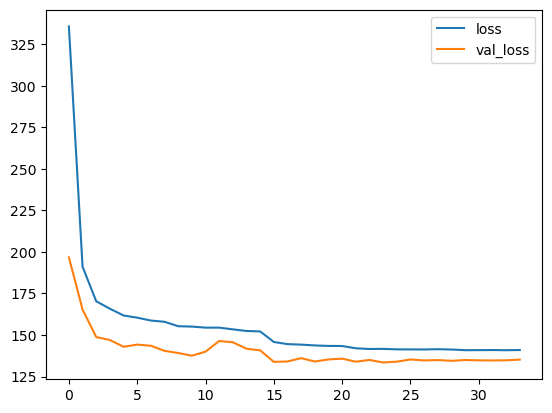

In [ ]:
plt.plot(logs.history['vae_loss'], label="loss")
plt.plot(logs.history['val_vae_loss'], label="val_loss")
plt.legend()
plt.show()

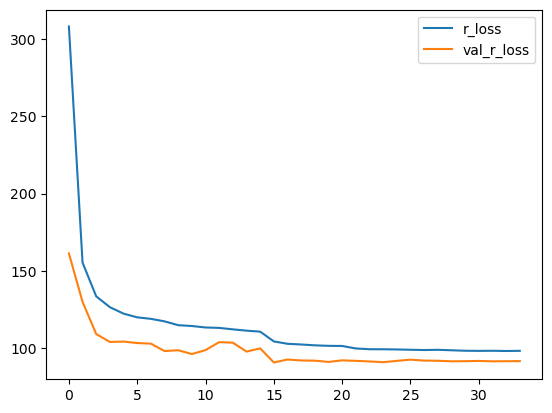

In [ ]:
plt.plot(logs.history['r_loss'], label="r_loss")
plt.plot(logs.history['val_r_loss'], label="val_r_loss")
plt.legend()
plt.show()

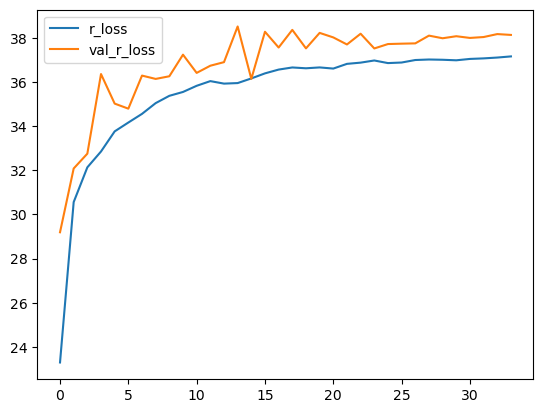

In [ ]:
plt.plot(logs.history['kl_loss'], label="kl_loss") #A mistake, I forgot to change the labels
plt.plot(logs.history['val_kl_loss'], label="val_kl_loss")
plt.legend()
plt.show()

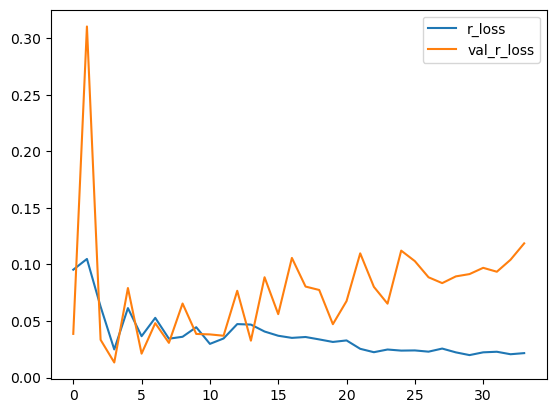

In [ ]:
plt.plot(logs.history['disc_loss'], label="disc_loss") #A mistake, I forgot to change the labels
plt.plot(logs.history['val_disc_loss'], label="val_disc_loss")
plt.legend()
plt.show()

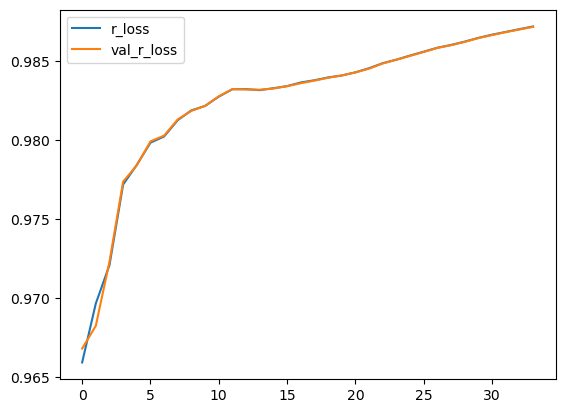

In [ ]:
plt.plot(logs.history['disc_acc'], label="disc_acc") #A mistake, I forgot to change the labels
plt.plot(logs.history['val_disc_acc'], label="val_disc_acc")
plt.legend()
plt.show()

# Testing

In [9]:
# optional
vae = keras.models.load_model(model_path, custom_objects={'Sampling': Sampling}, compile=False)
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 encoder (Functional)           [(None, 32),         2255296     ['input_3[0][0]',                
                                 (None, 32),                      'input_4[0][0]']                
                                 (None, 32)]                                                    

13/13 [==============================] - 1s 19ms/step


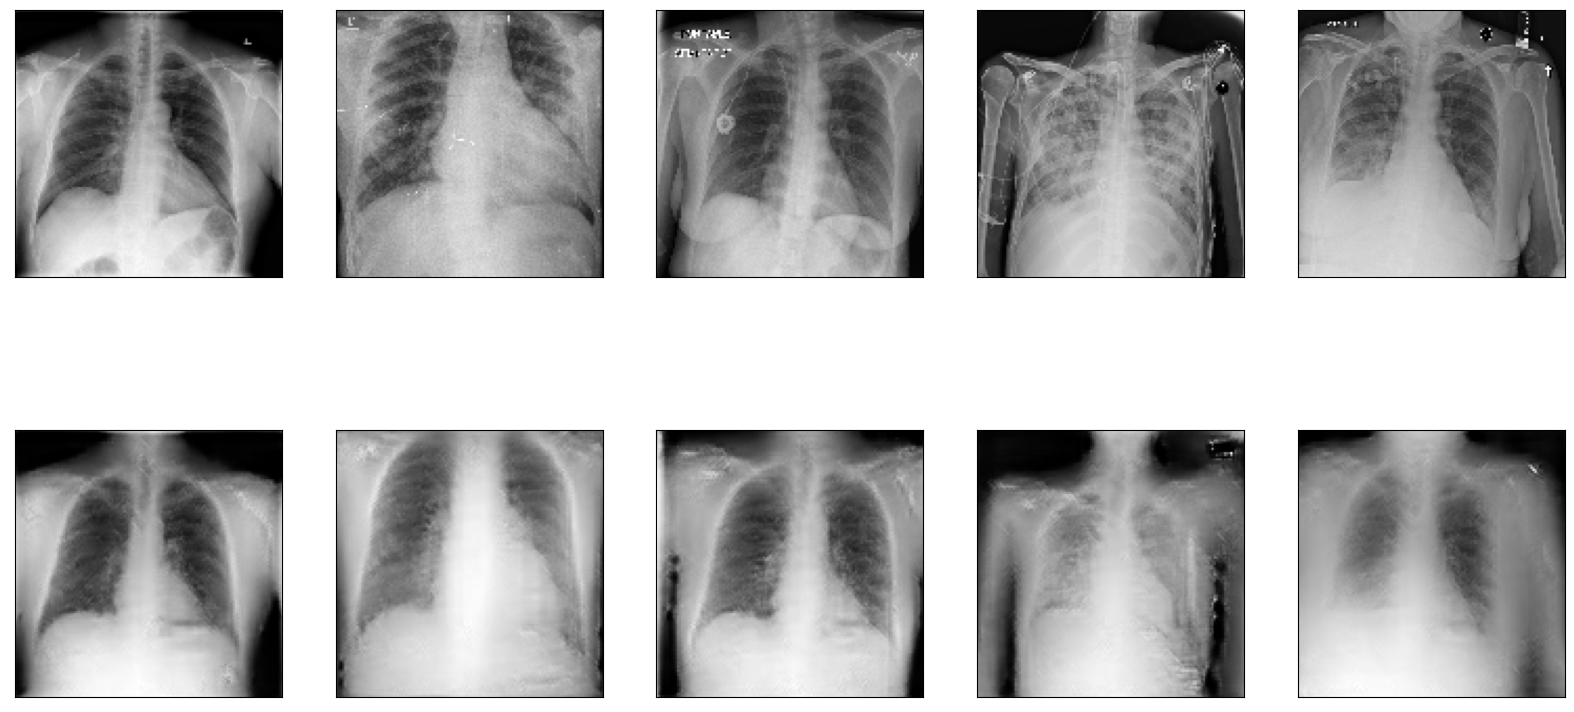

In [ ]:
decoded_imgs = vae.predict([X_test, y_test])

n = 5
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Sampling a image from noise

In [11]:
decoder = vae.get_layer("decoder")

In [20]:
batch = 4
classes = np.array([0,0,1,1])
cond_inp_str = np.where(classes==0, "negative", "positive")

ruido = np.random.randn(batch, latent_dim)
gen_imgs = decoder.predict([ruido, classes])
gen_imgs.shape

1/1 [==============================] - 0s 71ms/step


(4, 128, 128, 1)

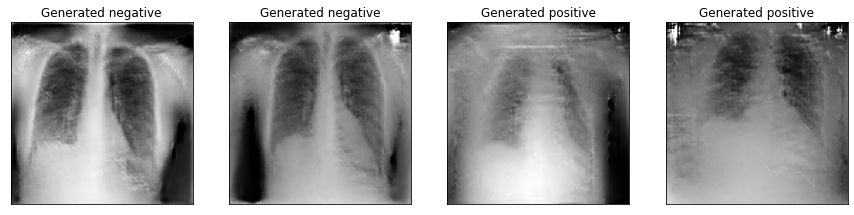

In [21]:
plt.figure(figsize=(15, 8))
for i in range(1,batch+1):
    ax = plt.subplot(1, batch, i)
    ax.imshow(np.squeeze(gen_imgs[i-1]), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"Generated {cond_inp_str[i-1]}")
plt.show()